In [1]:
import numpy as np
import matplotlib.pyplot as plt
import log_bessel as lb
from scipy.integrate import quad, fixed_quad
from scipy.special import kv

params = {'xtick.labelsize': 16,
          'ytick.labelsize': 16,
          'legend.fontsize': 16,
          'font.size': 16,
          'legend.fancybox': True,
          'axes.grid': True}

plt.rcParams.update(params)

# SciPy function bounds test

In [2]:
v_to_test = np.logspace(-5, np.log10(5000), 5000)
z_to_test = np.logspace(-5, np.log10(5000), 5000)

res = np.zeros((5000,5000))

def function_test(v):
    
    return np.log(kv(v, z_to_test))

In [4]:
for i in range(5000):
    
    res[i] = function_test(v_to_test[i])

/home/jacob/anaconda3/envs/pulsar_timing/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log
  


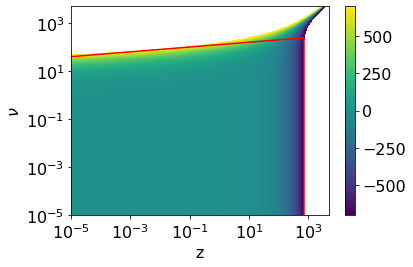

In [5]:
plt.yscale('log', basey=10)
plt.xscale('log', basex=10)

zz, vv = np.meshgrid(z_to_test,v_to_test)
err = plt.pcolormesh(zz, vv, res) #
plt.colorbar(err)
plt.plot(z_to_test[z_to_test<=700], 127 * z_to_test[z_to_test<=700]**0.1, c='r')

plt.vlines(700, ymin=1E-5, ymax=(127 * z_to_test[z_to_test<=700]**0.1)[-1], color='r')
plt.xlabel('z')
plt.ylabel(r'$\nu$')
plt.tight_layout()
plt.savefig('Plots/scipy_bessel_bounds.png')

In [6]:
v_to_test2 = 127*z_to_test**0.1

res2 = np.zeros(5000)

for i in range(5000):
    
    res2[i] = np.log(kv(v_to_test2[i], z_to_test[i]))

res2_abs = np.abs(res2)

print('No. of infs on full z range')
print(np.count_nonzero(res2_abs==np.inf))
print('\n')

z_max_1 = 700
print(f'No. of infs with z_max={z_max_1}')
print(np.count_nonzero(res2_abs[z_to_test<=z_max_1]==np.inf))
print('\n')

z_max_2 = 650
print(f'No. of infs with z_max={z_max_2}')
print(np.count_nonzero(res2_abs[z_to_test<=z_max_2]==np.inf))
print('\n')

No. of infs on full z range
478


No. of infs with z_max=700
0


No. of infs with z_max=650
0




/home/jacob/anaconda3/envs/pulsar_timing/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys


# Method regimes plot

In [97]:
def scipy_bound(z):
    
    return 127*z**0.1

def rothwell_bound(z):
    
    b1 = 300 / (np.log(z)+np.log(2)) + 0.5
    b2 = 0.5
    
    b1[b1>50] = np.nan
    
    return b1

def trap_bound_upper(z):
    
    asymp_v_slope = 1
    asymp_v_intercept = 8
    
    return np.exp(asymp_v_intercept)*z**asymp_v_slope

def trap_bound_lower(z):
    
    asymp_z_slope = 1
    asymp_z_intercept = -3
    
    bounds = np.ones(len(z))*100
    b1 = z
    b2 = np.exp(asymp_z_intercept)*z**asymp_z_slope
    
    i_b2 = b2>100
    bounds[i_b2] = b2[i_b2]
    
    i_b1 = b1 < 100
    bounds[i_b1] = b1[i_b1]
    
    return bounds

def asymp_v_bound(z):
    
    b1 = scipy_bound(z)
    b2 = trap_bound_upper(z)
    
    i = b2>b1
    b1[i] = b2[i]
    
    return b1

def trap_lower_plot(z):
    
    b1 = scipy_bound(z)
    b2 = trap_bound_lower(z[z>7E2])
    
    b1[z>7E2] = b2
    
    return b1

In [98]:
logmin = -5
logmax = 8
z = np.logspace(logmin, logmax, 7500)

scipy_bounds = scipy_bound(z[z<=7E2])
rothwell_bounds = rothwell_bound(z[z>7E2])

z_trap_upper = z[scipy_bound(z)<=trap_bound_upper(z)][0]
trap_upper_bounds = trap_bound_upper(z[z>=z_trap_upper])
trap_lower_bounds = trap_bound_lower(z[z>7E2])

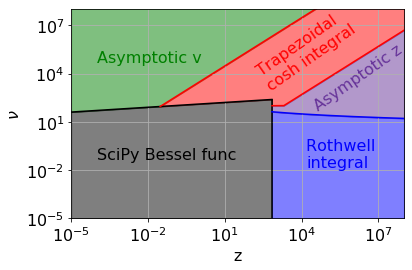

In [99]:
fig1, ax1 = plt.subplots()

ax1.set(xlabel='z', ylabel=r'$\nu$', yscale='log', xscale='log')
ax1.set_xlim(10**logmin, z[-1])
ax1.set_ylim(10**logmin, trap_upper_bounds[-1])

ax1.plot(z[z<=7E2], scipy_bounds, c='k')
ax1.vlines(7E2, 10**logmin, scipy_bounds[-1], color='k')

ax1.plot(z[z>7E2], rothwell_bounds, c='b')

ax1.plot(z[z>=z_trap_upper], trap_upper_bounds, c='r')
ax1.plot(z[z>7E2], trap_lower_bounds, c='r')

alpha=0.5

z_trap = z[z>=z_trap_upper]
ax1.fill_between(z, asymp_v_bound(z), np.ones(len(z))*trap_upper_bounds[-1], color='g', alpha=alpha)
ax1.fill_between(z_trap, trap_lower_plot(z_trap), trap_upper_bounds, color='r', alpha=alpha)
ax1.fill_between(z[z<=7E2], np.ones(len(z[z<=7E2]))*10**logmin, scipy_bounds, color='k', alpha=alpha)
ax1.fill_between(z[z>7E2], np.ones(len(z[z>7E2]))*10**logmin, rothwell_bounds, color='b', alpha=alpha)
ax1.fill_between(z[z>7E2], rothwell_bounds, trap_lower_bounds, color='rebeccapurple', alpha=alpha)

ax1.text(1E-4,5E4, 'Asymptotic v', color='g')
ax1.text(1.5E2, 1E3, 'Trapezoidal \ncosh integral', rotation=35, color='r')
ax1.text(1E-4, 5E-2, 'SciPy Bessel func', color='k')
ax1.text(1.5E4, 1.5E-2, 'Rothwell \nintegral', color='b')
ax1.text(2.5E4, 0.5E2, 'Asymptotic z', rotation =35, color='rebeccapurple')


ax1.set_ylim(1E-5,1E8)
fig1.tight_layout()

plt.savefig('Plots/method_regions.pdf')

# Relative error plot

In [4]:
def logdiffexp(x1,x2):
    
    x1 = np.longdouble(x1)
    x2 = np.longdouble(x2)
    
    return x1+np.log1p(-np.exp(-(x1-x2)))

def forward_recursion(v,z):
    
    first = lb.log_bessel_k(v+2,z)
    second = np.log(2) + np.log(np.longdouble(v+1)) - np.log(np.longdouble(z)) + lb.log_bessel_k(v+1,z)
    
    return logdiffexp(first, second)

def backward_recursion(v, z):
    
    first = lb.log_bessel_k(v-2, z)
    second = np.log(2)+np.log(v-1)-np.log(z)+lb.log_bessel_k(v-1, z)
    
    return np.logaddexp(first, second)

def recursion_test(v, z):
    
    rhs = np.zeros(np.shape(v))
    
    i_forward = v <= 1.
    i_backward = v > 1.
    
    if v<=1:
        rhs = forward_recursion(v, z)
    else:
        rhs = backward_recursion(v, z)
    
    lhs = lb.log_bessel_k(v, z)
    
    return np.abs(lhs/rhs-1)#, indices_forward, indices_backward

In [87]:
logmin = -5
logmax = 5

z = np.logspace(logmin, logmax, 7500)
v = np.logspace(logmin, logmax, 7500)

zz, vv = np.meshgrid(z, v)

In [9]:
rel_err_res = np.zeros((7500,7500))

for i in range(len(rel_err_res)):
    
    if i % 750 == 0:
        print(f'{i/7500 *100} %')
        
    rel_err_res[:, i] = recursion_test(v, z[i])

0.0 %
10.0 %
20.0 %
30.0 %
40.0 %
50.0 %
60.0 %
70.0 %
80.0 %
90.0 %


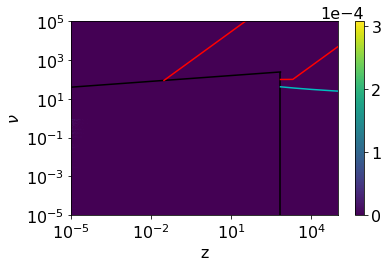

In [11]:
fig2, ax2 = plt.subplots()
ax2.set(xlabel='z', ylabel=r'$\nu$', yscale='log', xscale='log')

rel_err = ax2.pcolormesh(zz, vv, rel_err_res)
cbar = fig2.colorbar(rel_err)

cbar.formatter.set_powerlimits((0, 0))
cbar.update_ticks()

ax2.set_xlim(10**logmin, z[-1])
ax2.set_ylim(10**logmin, trap_upper_bounds[-1])

ax2.plot(z[z<=7E2], scipy_bounds, c='k')
ax2.vlines(7E2, 10**logmin, scipy_bounds[-1], color='k')

ax2.plot(z[z>7E2], rothwell_bounds, c='c')

ax2.plot(z[z>=z_trap_upper], trap_upper_bounds, c='r')
ax2.plot(z[z>7E2], trap_lower_bounds, c='r')

#ax2.set_ylim(10**logmin, v[-1])

fig2.tight_layout()

#plt.savefig('Plots/relative_error.png')

In [30]:
np.median(rel_err_res)

2.220446049250313e-16

# MATERN TEST

In [7]:
B0105 = np.loadtxt('Data/B0105+64.asc', usecols=(0,1,2,7))
x = B0105[:, 0]
y = B0105[:, 1]

import gaussian_process as gp

In [8]:
theta = np.array([1,42.4242, 1])
matern = gp.matern(theta, x)

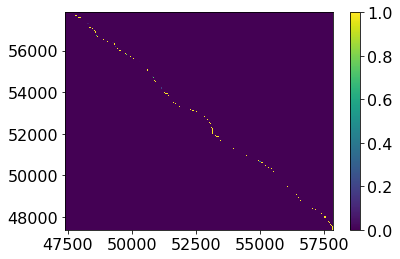

In [9]:
y = np.flip(x)
xx, yy = np.meshgrid(x,y)

fig3, ax3 = plt.subplots()

cov_matrix = ax3.pcolormesh(xx, yy, matern)
fig3.colorbar(cov_matrix)